In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

In [2]:
from lib.environments.classic import adversarialHumanoid

envs.register_environment('custom_humanoid', adversarialHumanoid)

In [3]:
env_name = "custom_humanoid" # @param ["ant","halfcheetah","hopper","humanoid","humanoidstandup","inverted_pendulum","inverted_double_pendulum","pusher","reacher","walker2d","custom_humanoid"]
backend = "mjx" # @param ["generalized","positional","spring","mjx"]

env = envs.get_environment(env_name=env_name, rng=jax.random.PRNGKey(0), disc_path='weights/discriminator.pkl',
                           backend=backend)

00:02:16: 39.60


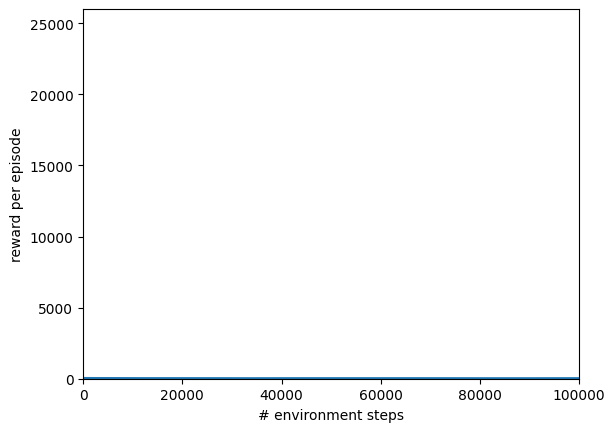

time to jit: 0:00:29.124109
time to train: 0:01:47.009213


In [10]:
# train_fn=functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1)

train_fn = functools.partial(
    sac.train,
    num_timesteps=100_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    discounting=0.97,
    learning_rate=3e-4,
    num_envs=512,
    batch_size=256,
    seed=1,
    tau=0.005,             # target smoothing coefficient (typical SAC value)
    # hidden_layer_sizes=(256, 256),  # default policy + critic network sizes
    # entropy_cost=1e-3      # encourages exploration
)

max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'custom_humanoid': 26000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
start_time=datetime.now()
times = [start_time]

def format_elapsed_time(seconds):
    """Converts elapsed seconds to HH:MM:SS format"""
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  current_time = datetime.now()
  elapsed_seconds = (current_time - start_time).total_seconds()  # Compute elapsed time in seconds
  elapsed_time_str = format_elapsed_time(elapsed_seconds)
  print(f"{elapsed_time_str}: {ydata[-1]:.2f}")
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [5]:
model.save_params('weights/params_adversarial_recreation.pkl', params)
params = model.load_params('weights/params_adversarial_recreation.pkl')
inference_fn = make_inference_fn(params)

In [6]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, rng=jax.random.PRNGKey(seed=0), disc_path='weights/discriminator.pkl', backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

In [7]:
from lib.utils.viz import *

create_interactive_rollout(env=env, rollout=rollout, headless=False)

Rollout successful, saved at /home/mukundan/Desktop/Summer_SEM/imitation_learning/temp.html


Opening in existing browser session.
